# Recherche de facteurs d'influence sur le temps de sommeil
_Darnatigues R√©my / Guiraud Philippe_

## Nous allons ici proc√©der √† une r√©gression lin√©aire multiple portant sur nos donn√©es en ne prenant que les hommes.
_Par manque de temps, les hypoth√®ses sont simplement v√©rifi√©es mais aucune solution pour les r√©gler n'a √©t√© r√©alis√©e. On retrouve ainsi la m√™me pr√©sentation que le pr√©c√©dent notebook._

## 1] La th√©orie

Le mod√®le et nos hypoth√®ses restent les m√™mes que pour la r√©gression initiale. Les observations ne concernant que les hommes nous gardons alors 189 lignes dans nos donn√©es.

## 2] Application

### a) Cr√©ation du mod√®le

Voici les diff√©rentes variables qui constituent notre probl√®me de r√©gression lin√©aire : <br />

**Variable √† expliquer** : le temps de sommeil que l'on note Y <br />

**Variables explicatives** : <br />
  - l'√¢ge, not√© $X_{1}$ ou age<br />
  - le temps d'activit√©, not√© $X_{2}$ ou activ<br />
  - le battement cardiaque au repos, not√© $X_{3}$ ou battement<br />
  - la pression systolique, not√© $X_{4}$ ou systolique<br />
  - la pression diastolique, not√©e $X_{5}$ ou diastolique<br />
  - le nombre de pas quotidien, not√© $X_{6}$ ou pas<br />
  - le stress, not√© $X_{7}$ ou stress<br />
  
Les variables $a_{0}, a_{1}, a_{2}, a_{3}, a_{4}, a_{5}, a_{6}, a_{7}$ sont les param√®tres √† estimer de notre mod√®le.

**Notre mod√®le est le suivant :
$Y_{i} = a_{0} + a_{1}X_{i,1} + a_{2}X_{i,2} +a_{3}X_{i,3} + a_{4}X_{i,4} + a_{5}X_{i,5} + a_{6}X_{i,6} + a_{7}X_{i,7} +  \epsilon_{i}$**

Ci-dessous, nous r√©cup√©rons les donn√©es associ√©es √† chaque variable que nous stockons dans un dataframe $X$ dont les colonnes sont nos $X_{i}$.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.stats.diagnostic as smd
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from scipy.stats import shapiro, normaltest
from scipy.stats import shapiro, jarque_bera
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import cross_val_score
from statsmodels.stats.diagnostic import linear_reset
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from scipy.stats import boxcox
from IPython.display import display


fichier = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv", sep=",")
fichier.drop('Person ID', axis = 1, inplace = True)
systolique = []  # valeur 1
diastolique = []  # valeur 2
for value in fichier["Blood Pressure"]:
    val_1, val_2 = value.split('/')
    systolique.append(int(val_1))  
    diastolique.append(int(val_2)) 
fichier['Systolic'] = systolique
fichier['Diastolic'] = diastolique
fichier.drop('Blood Pressure', axis = 1, inplace = True)
fichier["Sleep Disorder"] = fichier["Sleep Disorder"].fillna("Aucun")
fichier["BMI Category"] = fichier["BMI Category"].replace({"Normal Weight": "Normal"})
indice_hommes = np.where(fichier["Gender"] == "Male")
Y = fichier.iloc[indice_hommes]["Sleep Duration"]
age = fichier.iloc[indice_hommes]["Age"]
activ = fichier.iloc[indice_hommes]["Physical Activity Level"]
battement = fichier.iloc[indice_hommes]["Heart Rate"]
pas = fichier.iloc[indice_hommes]["Daily Steps"]
stress = fichier.iloc[indice_hommes]["Stress Level"]
systolique = fichier.iloc[indice_hommes]["Systolic"]
diastolique = fichier.iloc[indice_hommes]["Diastolic"]

X_unscaled = pd.DataFrame(np.column_stack([Y, age, activ, battement, systolique, diastolique, pas, stress]),
                 columns=['Y', 'age', 'activ', 'bpm', 'syst', 'diast', 'pas', 'stress'])

### b) Normalisation des donn√©es

Nous normalisons les donn√©es pour √©viter l'influence des diff√©rentes √©chelles des variables sur notre analyse.

In [2]:
# S√©parer la variable cible 'Y' des variables explicatives
Y = X_unscaled['Y'].values  # Extraire Y sous forme de tableau NumPy
X_features = X_unscaled.drop(columns=['Y'])  # Conserver seulement les variables explicatives

# Appliquer la normalisation 
scaler = MinMaxScaler()
X_standardized = scaler.fit_transform(X_features)  # Transforme les donn√©es

# Convertir en DataFrame avec les m√™mes noms de colonnes
X = pd.DataFrame(X_standardized, columns=X_features.columns)

# V√©rification : Moyenne ~ 0 et √âcart-Type ~ 1
print("Moyennes apr√®s normalisation :", X.mean().round(4))
print("√âcarts-types apr√®s normalisation :", X.std().round(4))

# R√©int√©grer Y si besoin
X.insert(0, 'Y', Y)

Moyennes apr√®s normalisation : age       0.4579
activ     0.4867
bpm       0.2882
syst      0.3977
diast     0.4385
pas       0.5420
stress    0.6159
dtype: float64
√âcarts-types apr√®s normalisation : age       0.2574
activ     0.3450
bpm       0.1724
syst      0.2036
diast     0.1887
pas       0.2144
stress    0.2600
dtype: float64


Une fois les donn√©es normalis√©es, nous v√©rifions nos hypoth√®ses de d√©part.

### c) V√©rification des hypoth√®ses de d√©part

##### Hypoth√®se 1 : Toutes les corr√©lations ne doivent pas √™tre nulles.  

Pour la v√©rifier on rappelle la matrice de corr√©lation de notre mod√®le.

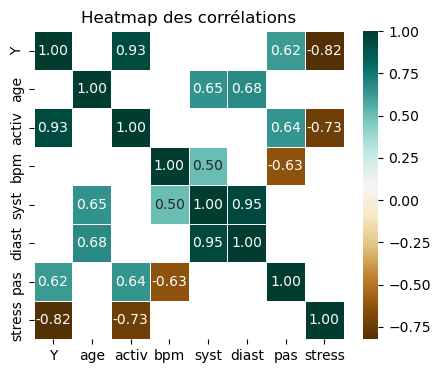

In [3]:
plt.figure(figsize=(5, 4))  # Taille du graphique
sns.heatmap(X.corr()[X.corr().abs() > 0.5], annot=True, cmap="BrBG", fmt=".2f", linewidths=0.5)

plt.title("Heatmap des corr√©lations")
plt.show()

**L'hypoth√®se 1 est valid√©e.**

##### Hypoth√®se 2 : Les $X_{i}$ ne sont pas colin√©aires, *i.e.* pas de multicolin√©arit√© entre variables.

De la matrice de corr√©lation ci-dessus, les seules valeurs √©gales √† 1 sont les coefficients diagonaux.  
On remarque cependant une corr√©lation tr√®s forte entre les pressions systolique et diastolique.  
On r√©alise alors deux tests : le test du VIF et le test condition number avec H0 : il n'y a pas de multicolin√©arit√© entre variables.  

In [4]:
# Multicolin√©arit√©
X = X.drop(columns=['Y'])
X = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)
print("VIF (Variance Inflation Factor) :")

# Test de Multicolin√©arit√©
high_vif = vif_data[vif_data["VIF"] > 10]
if not high_vif.empty:
    print("Test de Multicolin√©arit√© (VIF) : Il y a une multicolin√©arit√© excessive entre certaines variables (rejette H0).")
else:
    print("Test de Multicolin√©arit√© (VIF) : Il n'y a pas de multicolin√©arit√© excessive (ne rejette pas H0).")

  feature        VIF
0   const  52.711829
1     age   2.504841
2   activ   4.043728
3     bpm   4.055252
4    syst  18.781584
5   diast  22.416645
6     pas   4.937304
7  stress   3.158313
VIF (Variance Inflation Factor) :
Test de Multicolin√©arit√© (VIF) : Il y a une multicolin√©arit√© excessive entre certaines variables (rejette H0).


**L'hypoth√®se 2 est rejet√©e**  
Les tests rejettent la non-colin√©arit√©, on remarque que ce r√©sultat est d√ª √† une colin√©arit√© forte entre les pressions systolique et diastolique.  
Nous prenons la d√©cision d'enlever la variable diastolique de notre mod√®le puisque c'est celle ayant le VIF le plus √©lev√©. Nous r√©alisons de nouveau le test VIF, et ajoutons √† celui-ci le test du Condition Number pour tester s'il y a une combinaison lin√©aire de variable avec une forte multicolin√©arit√©.

In [5]:
X_syst = X.drop(columns=['diast'])

In [6]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_syst.columns
vif_data["VIF"] = [variance_inflation_factor(X_syst.values, i) for i in range(X_syst.shape[1])]
print(vif_data)
print("VIF (Variance Inflation Factor) :")

# Test de Multicolin√©arit√©
high_vif = vif_data.loc[vif_data.index[1:]]
high_vif = high_vif[high_vif["VIF"] > 10]
if not high_vif.empty:
    print("Test de Multicolin√©arit√© (VIF) : Il y a une multicolin√©arit√© excessive entre certaines variables (rejette H0).")
else:
    print("Test de Multicolin√©arit√© (VIF) : Il n'y a pas de multicolin√©arit√© excessive (ne rejette pas H0).")

# Test Condition Number

condition_number = np.linalg.cond(X_syst)
print(f'Condition Number: {condition_number}')
if condition_number > 30:
    print("Test de Multicolin√©arit√© (Condition Number) : Il y a une multicolin√©arit√© excessive (rejette H0).")
else:
    print("Test de Multicolin√©arit√© (Condition Number) : Il n'y a pas de multicolin√©arit√© excessive (ne rejette pas H0).")

  feature        VIF
0   const  51.900036
1     age   2.244563
2   activ   3.916908
3     bpm   2.690270
4    syst   2.980729
5     pas   3.224757
6  stress   2.742230
VIF (Variance Inflation Factor) :
Test de Multicolin√©arit√© (VIF) : Il n'y a pas de multicolin√©arit√© excessive (ne rejette pas H0).
Condition Number: 20.274928142228937
Test de Multicolin√©arit√© (Condition Number) : Il n'y a pas de multicolin√©arit√© excessive (ne rejette pas H0).


Les tests VIF et Condition Number valident la non-colin√©arit√© des variables.  
**L'hypoth√®se 1 est valid√©e.**

***Une fois les hypoth√®ses de d√©part v√©rifi√©es nous pouvons r√©aliser une r√©gression lin√©aire multiple sur le mod√®le retenu.***

## 3] R√©gression lin√©aire multiple

#### R√©alisons une r√©gression multiple sur notre mod√®le en prenant en compte toutes les variables quantitatives explicatives, except√© la pression systolique, et tous les individus.

On introduit le code de la r√©gression multiple, qui nous fournira la matrice des coefficients ainsi que le R2.

In [7]:
def regression_multiple(*vars_exp, Y):
    # Conversion des listes en tableau NumPy
    X = np.column_stack(vars_exp)  # Regroupe les variables explicatives en colonnes
    Y = np.array(Y)  # Conversion de Y en array

    n, p = X.shape  # Nombre d'observations et nombre de variables explicatives

    # Ajout de la colonne de 1 pour l'ordonn√©e √† l'origine (Œ≤0)
    X_b = np.c_[np.ones(n), X]

    # Estimation des coefficients avec la formule des moindres carr√©s : Œ≤ = (X'X)^-1 X'Y
    theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(Y)

    # Pr√©dictions du mod√®le
    Y_pred = X_b.dot(theta)

    # Calcul du R¬≤ : 1 - (SCE / SCT)
    SCE = np.sum((Y - Y_pred) ** 2)  # Somme des carr√©s des erreurs
    SCT = np.sum((Y - np.mean(Y)) ** 2)  # Somme totale des carr√©s
    R2 = 1 - (SCE / SCT)

    # **Calcul du R¬≤ ajust√©**
    R2_adj = 1 - ((1 - R2) * (n - 1) / (n - p - 1))

    # **Calcul des erreurs standards des coefficients**
    sigma2 = SCE / (n - p - 1)  # Variance des r√©sidus
    var_theta = sigma2 * np.linalg.inv(X_b.T.dot(X_b))  # Matrice de variance-covariance
    se_theta = np.sqrt(np.diag(var_theta))  # Erreur standard de chaque coefficient

    # **Test de Student pour chaque coefficient**
    t_stats = theta / se_theta  # Statistique t
    p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=n - p - 1))  # p-valeurs bilat√©rales

    # **Test de Fisher pour l'ensemble du mod√®le**
    MSR = (SCT - SCE) / p  # Moyenne des carr√©s de la r√©gression
    MSE = SCE / (n - p - 1)  # Moyenne des carr√©s des erreurs
    F_stat = MSR / MSE  # Statistique F
    p_value_F = 1 - stats.f.cdf(F_stat, dfn=p, dfd=n - p - 1)  # p-valeur associ√©e

    return theta, R2, R2_adj, t_stats, p_values, F_stat, p_value_F

In [8]:
theta1, R2_1, R2_aj1, t_stats1, p_values1, F_stat1, p_value_F1 = regression_multiple(X['age'], X['activ'], X['bpm'], X['diast'], X['pas'], X['stress'], Y=Y)

print("Coefficients:", theta1)
print("R¬≤:", R2_1)
print("R2 ajust√© :", R2_aj1)
print("Statistiques t:", t_stats1)
print("p-valeurs:", p_values1)
print("Statistique F:", F_stat1)
print("p-valeur du test F:", p_value_F1)

Coefficients: [ 7.20805443 -0.21686505  1.3591452   0.39018619 -0.5842993   0.14790221
 -1.08809084]
R¬≤: 0.9456282102344667
R2 ajust√© : 0.9438357336487898
Statistiques t: [ 84.95705315  -2.94571943  19.56176327   2.99802085  -4.87776658
   1.42348564 -13.68081015]
p-valeurs: [0.00000000e+00 3.64323207e-03 0.00000000e+00 3.09727268e-03
 2.33181731e-06 1.56307448e-01 0.00000000e+00]
Statistique F: 527.5540097933017
p-valeur du test F: 1.1102230246251565e-16


#### 1) Lin√©arite 

On affiche le graphique des r√©sidus et des valeurs ajust√©es pour voir si une tendance se dessine pour invalider l'hypoth√®se, et on r√©alise aussi le test de Ramsey-RESET.

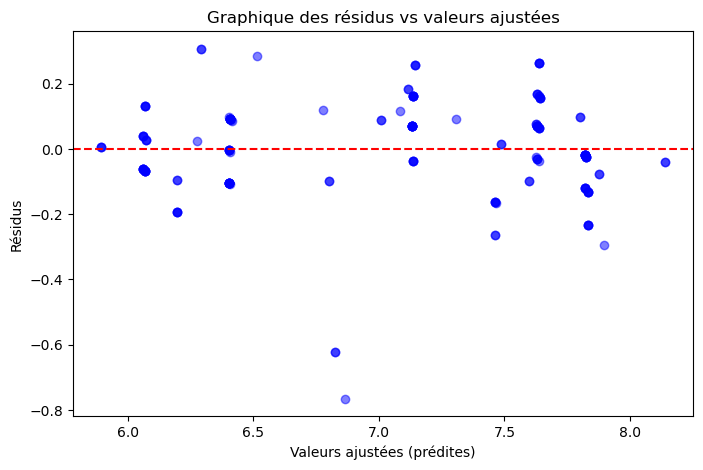

In [9]:
#   R√©gression lin√©aire
model = sm.OLS(Y, X_syst).fit()
Y_pred = model.predict(X_syst)

#   Calcul des r√©sidus
residuals = Y - Y_pred

#   Affichage du scatterplot des r√©sidus
plt.figure(figsize=(8, 5))
plt.scatter(Y_pred, residuals, alpha=0.5, color="blue")
plt.axhline(y=0, color="red", linestyle="--")  # Ligne de r√©f√©rence √† 0
plt.xlabel("Valeurs ajust√©es (pr√©dites)")
plt.ylabel("R√©sidus")
plt.title("Graphique des r√©sidus vs valeurs ajust√©es")
plt.show()

In [10]:
#   Test de Ramsey RESET
reset_test = linear_reset(model, power=2, test_type='fitted')

#   Affichage des r√©sultats
print("R√©sultat du test de Ramsey RESET :")
print(reset_test)

#   Interpr√©tation du test
alpha = 0.05  # Seuil de significativit√© (5%)
p_value = reset_test.pvalue  # R√©cup√©ration de la p-value

if p_value > alpha:
    print("‚úÖ L'hypoth√®se de lin√©arit√© est valid√©e (p-value =", round(p_value, 4), ")")
else:
    print("‚ùå L'hypoth√®se de lin√©arit√© est rejet√©e (p-value =", round(p_value, 4), ")")

R√©sultat du test de Ramsey RESET :
<Wald test (chi2): statistic=8.33459531054503, p-value=0.0038897141702983647, df_denom=1>
‚ùå L'hypoth√®se de lin√©arit√© est rejet√©e (p-value = 0.0039 )


#### 2) Significativit√© des coefficients

On r√©alise le test de Student sur les coefficients et le test de Fisher sur le mod√®le global pour v√©rifier la significativit√© des coefficients.

In [11]:
# Ex√©cution de la r√©gression multiple avec les noms des variables
var_names = ["age", "activ", "battement", "diastolique", "pas", "stress"]
theta1, R2_1, R2_aj1, t_stats1, p_values1, F_stat1, p_value_F1 = regression_multiple(X['age'], X['activ'], X['bpm'], X['diast'], X['pas'], X['stress'], Y=Y)

# **Affichage des r√©sultats**
print("=== R√©sultats de la r√©gression lin√©aire multiple ===")
print(f"R¬≤ du mod√®le : {R2_1:.4f}\n")

print("--- Test de Student (t-test) ---")
print(f"Intercept : t = {t_stats1[0]:.4f}, p-value = {p_values1[0]:.4f} {'*' if p_values1[0] < 0.05 else ''}")
for i, (name, t, p) in enumerate(zip(var_names, t_stats1[1:], p_values1[1:]), start=1):
    print(f"{name} : t = {t:.4f}, p-value = {p:.4f} {'*' if p < 0.05 else ''}")

print("\n--- Test de Fisher (F-test) ---")
print(f"Statistique F = {F_stat1:.4f}, p-value = {p_value_F1:.4f}")

# **Interpr√©tation rapide**
if p_value_F1 < 0.05:
    print("Le mod√®le global est statistiquement significatif.")
else:
    print("Le mod√®le global n'est PAS statistiquement significatif.")

# V√©rification des coefficients significatifs
significatifs = [name for name, p in zip(var_names, p_values1[1:]) if p < 0.05]
if significatifs:
    print(f"Les variables significatives sont : {', '.join(significatifs)}")
else:
    print("Aucune variable explicative n'est significative au seuil de 5%.")


=== R√©sultats de la r√©gression lin√©aire multiple ===
R¬≤ du mod√®le : 0.9456

--- Test de Student (t-test) ---
Intercept : t = 84.9571, p-value = 0.0000 *
age : t = -2.9457, p-value = 0.0036 *
activ : t = 19.5618, p-value = 0.0000 *
battement : t = 2.9980, p-value = 0.0031 *
diastolique : t = -4.8778, p-value = 0.0000 *
pas : t = 1.4235, p-value = 0.1563 
stress : t = -13.6808, p-value = 0.0000 *

--- Test de Fisher (F-test) ---
Statistique F = 527.5540, p-value = 0.0000
Le mod√®le global est statistiquement significatif.
Les variables significatives sont : age, activ, battement, diastolique, stress


#### 3) Moyenne des r√©sidus nulle 

On affiche l'histogramme des r√©sidus et on r√©alise un test de Student sur les r√©sidus.

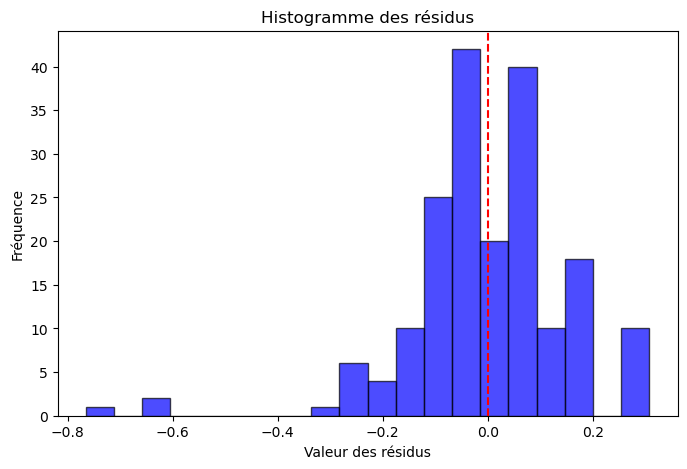

In [12]:
# üìä Affichage de l'histogramme des r√©sidus
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=20, edgecolor="black", alpha=0.7, color="blue")
plt.axvline(x=0, color="red", linestyle="--")  # Ligne verticale √† 0
plt.xlabel("Valeur des r√©sidus")
plt.ylabel("Fr√©quence")
plt.title("Histogramme des r√©sidus")
plt.show()

In [13]:
#   Test de Student (H0 : moyenne des r√©sidus = 0)
t_stat, p_value = stats.ttest_1samp(residuals, 0)

#   Affichage des r√©sultats
print(f"Statistique de test t : {t_stat:.4f}")
print(f"p-value : {p_value:.4f}")


if p_value > alpha:
    print("\n‚úÖ L'hypoth√®se d'une moyenne des r√©sidus nulle est valid√©e (p-value =", round(p_value, 4), ")")
else:
    print("\n‚ùå L'hypoth√®se est rejet√©e : la moyenne des r√©sidus est significativement diff√©rente de 0 (p-value =", round(p_value, 4), ")")
    print("üëâ Il peut y avoir un biais dans le mod√®le.")


Statistique de test t : 0.0000
p-value : 1.0000

‚úÖ L'hypoth√®se d'une moyenne des r√©sidus nulle est valid√©e (p-value = 1.0 )


C'est un r√©sultat auquel on s'attendait car on a ajout√© une constante au mod√®le.

#### 4) Non corr√©lation des r√©sidus

Il n'y a pas de temporalit√© ni de donn√©es ordonn√©es dans notre mod√®le, cette v√©rification n'est donc pas n√©cessaire.

#### 5) Homosc√©dasticit√© 

On r√©alise les tests de Breusch-Pagan et de White, ainsi qu'un diagramme des r√©sidus et des valeurs ajust√©es pour observer l'homosc√©dasticit√© du mod√®le.

In [14]:
X_features = X_syst

X_b = sm.add_constant(X_syst)
    
# Ajustement du mod√®le de r√©gression
model = sm.OLS(Y, X_b).fit()

# Extraction des r√©sidus
residuals = model.resid

# Test de Breusch-Pagan
bp_test = smd.het_breuschpagan(residuals, X_b)
bp_stat, bp_pvalue = bp_test[0], bp_test[1]  # Statistique du test et p-value

# Test de White
white_test = smd.het_white(residuals, X_b)
white_stat, white_pvalue = white_test[0], white_test[1]  # Statistique du test et p-value

# Affichage des r√©sultats
print("\n=== Test de Breusch-Pagan ===")
print(f"Statistique : {bp_stat:.4f}, p-value : {bp_pvalue:.4f}")
if bp_pvalue < 0.05:
    print("‚ö†Ô∏è H√©t√©rosc√©dasticit√© d√©tect√©e (rejette H0)")
else:
    print("‚úÖ Homosc√©dasticit√© confirm√©e (on ne rejette pas H0)")

print("\n=== Test de White ===")
print(f"Statistique : {white_stat:.4f}, p-value : {white_pvalue:.4f}")
if white_pvalue < 0.05:
    print("‚ö†Ô∏è H√©t√©rosc√©dasticit√© d√©tect√©e (rejette H0)")
else:
    print("‚úÖ Homosc√©dasticit√© confirm√©e (on ne rejette pas H0)")


=== Test de Breusch-Pagan ===
Statistique : 20.6371, p-value : 0.0021
‚ö†Ô∏è H√©t√©rosc√©dasticit√© d√©tect√©e (rejette H0)

=== Test de White ===
Statistique : 175.2617, p-value : 0.0000
‚ö†Ô∏è H√©t√©rosc√©dasticit√© d√©tect√©e (rejette H0)


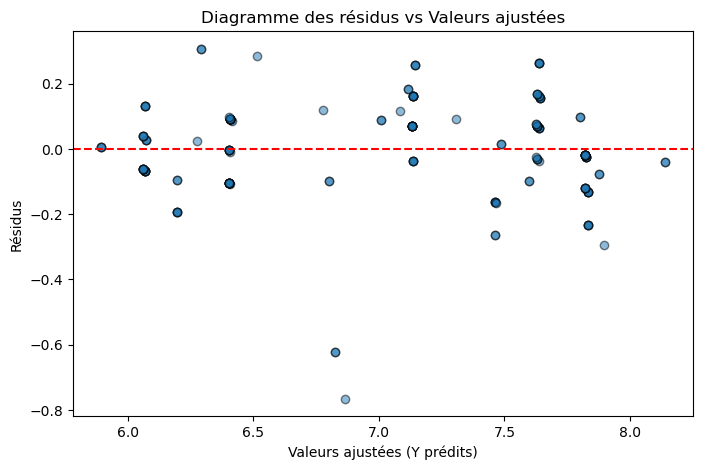

In [15]:
# üîπ Affichage du diagramme des r√©sidus vs valeurs ajust√©es
fitted_values = Y-residuals
plt.figure(figsize=(8, 5))
plt.scatter(fitted_values, residuals, alpha=0.5, edgecolors='black')
plt.axhline(y=0, color='red', linestyle='dashed')  # Ligne horizontale √† z√©ro

plt.xlabel("Valeurs ajust√©es (Y pr√©dits)")
plt.ylabel("R√©sidus")
plt.title("Diagramme des r√©sidus vs Valeurs ajust√©es")
plt.show()

On va donc s'occuper de l'h√©t√©rosc√©dasticit√© et tester plusieurs modifications du mod√®le, √† savoir :  
Mod√®le 1 : On applique le log √† Y  
Mod√®le 2 : On applique la racine √† carr√©e √† Y  
Mod√®le 3 : On applique le boxcox √† Y  
Mod√®le 4 : On utilise le WLS sur les r√©sidus  
Mod√®le 5 : On change le mod√®le en GLS  
Mod√®le 6 : On change le mod√®le avec une r√©gression quantile  
Mod√®le 7 : On change le mod√®le avec un mod√®le robuste  

In [16]:
liste_model = []
model_Ylog = sm.OLS(np.log(Y), X_b).fit()
liste_model.append(model_Ylog)
model_Ysqrt = sm.OLS(np.sqrt(Y), X_b).fit()
liste_model.append(model_Ysqrt)
Y_transformed, lambda_bc = boxcox(Y + 1e-6)
poids = 1 / (residuals**2 + 1e-6)
model_WLS = sm.WLS(Y, X_b, weights = poids).fit()
liste_model.append(model_WLS)
model_Yboxcox = sm.OLS(Y_transformed, X_b).fit()
liste_model.append(model_Yboxcox)
model_GLS = sm.GLS(Y, X_b).fit()
liste_model.append(model_GLS)
model_quantile = sm.QuantReg(Y, X_b).fit(q=0.5)
liste_model.append(model_GLS)
model_robuste = sm.OLS(Y, X_b).fit(cov_type='HC3')
liste_model.append(model_robuste)

In [17]:
model_resid = []
for i in range(len(liste_model)):
    model_resid.append(liste_model[i].resid)

On r√©applique les tests de Breusch-Pagan et White pour chacun des nouveaux mod√®les √† tester :  

In [18]:
for i in range(len(liste_model)):
    print("Pour le mod√®le", i+1, "voici les r√©sultats des tests :")
# Test de Breusch-Pagan
    bp_test = smd.het_breuschpagan(model_resid[i], X_b)
    bp_stat, bp_pvalue = bp_test[0], bp_test[1]  # Statistique du test et p-value

# Test de White
    white_test = smd.het_white(model_resid[i], X_b)
    white_stat, white_pvalue = white_test[0], white_test[1]  # Statistique du test et p-value

# Affichage des r√©sultats
    print("\n=== Test de Breusch-Pagan ===")
    print(f"Statistique : {bp_stat:.4f}, p-value : {bp_pvalue:.4f}")
    if bp_pvalue < 0.05:
        print("‚ö†Ô∏è H√©t√©rosc√©dasticit√© d√©tect√©e (rejette H0)")
    else:
        print("‚úÖ Homosc√©dasticit√© confirm√©e (on ne rejette pas H0)")

    print("=== Test de White ===")
    print(f"Statistique : {white_stat:.4f}, p-value : {white_pvalue:.4f}")
    if white_pvalue < 0.05:
        print("‚ö†Ô∏è H√©t√©rosc√©dasticit√© d√©tect√©e (rejette H0)\n")
    else:
        print("‚úÖ Homosc√©dasticit√© confirm√©e (on ne rejette pas H0)\n")

Pour le mod√®le 1 voici les r√©sultats des tests :

=== Test de Breusch-Pagan ===
Statistique : 21.0628, p-value : 0.0018
‚ö†Ô∏è H√©t√©rosc√©dasticit√© d√©tect√©e (rejette H0)
=== Test de White ===
Statistique : 174.8486, p-value : 0.0000
‚ö†Ô∏è H√©t√©rosc√©dasticit√© d√©tect√©e (rejette H0)

Pour le mod√®le 2 voici les r√©sultats des tests :

=== Test de Breusch-Pagan ===
Statistique : 20.7680, p-value : 0.0020
‚ö†Ô∏è H√©t√©rosc√©dasticit√© d√©tect√©e (rejette H0)
=== Test de White ===
Statistique : 175.0835, p-value : 0.0000
‚ö†Ô∏è H√©t√©rosc√©dasticit√© d√©tect√©e (rejette H0)

Pour le mod√®le 3 voici les r√©sultats des tests :

=== Test de Breusch-Pagan ===
Statistique : 28.9539, p-value : 0.0001
‚ö†Ô∏è H√©t√©rosc√©dasticit√© d√©tect√©e (rejette H0)
=== Test de White ===
Statistique : 178.4944, p-value : 0.0000
‚ö†Ô∏è H√©t√©rosc√©dasticit√© d√©tect√©e (rejette H0)

Pour le mod√®le 4 voici les r√©sultats des tests :

=== Test de Breusch-Pagan ===
Statistique : 21.0406, p-value : 0.0

On affiche aussi le diagramme des r√©sidus compar√© aux valeurs ajust√©es pour chaque mod√®le (rien ne change si ce n'est l'√©chelle).

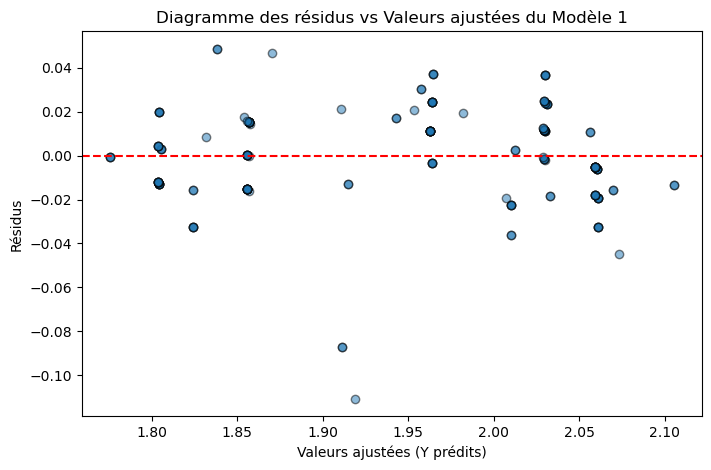

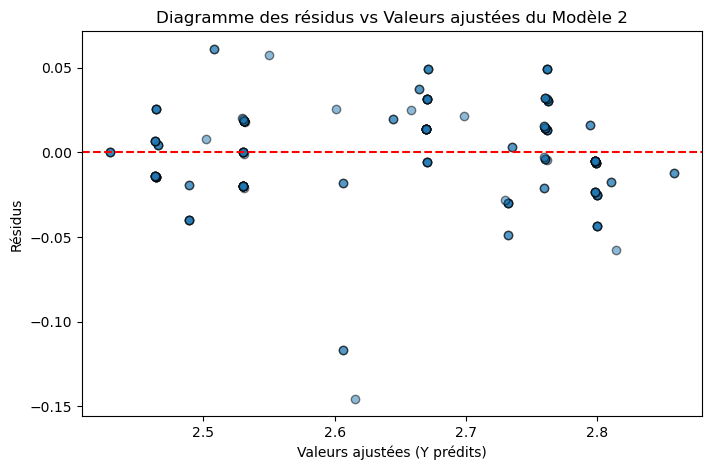

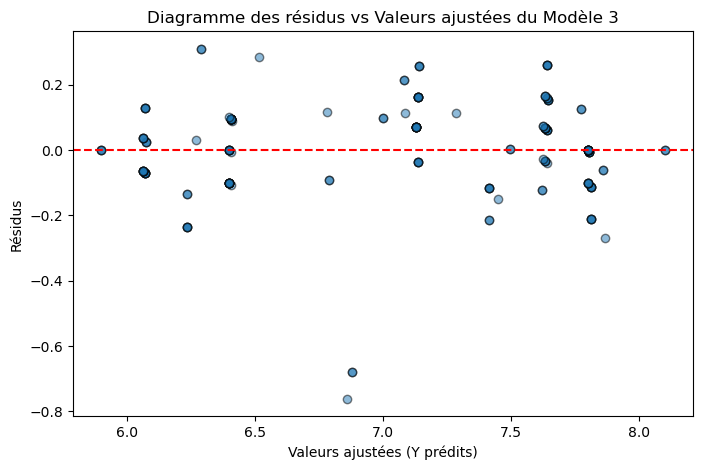

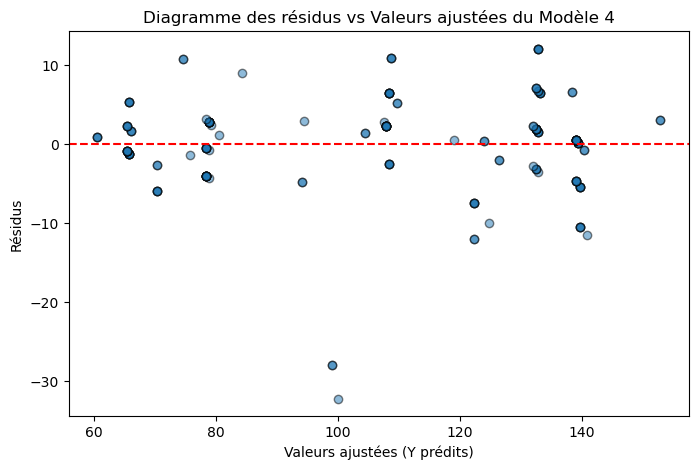

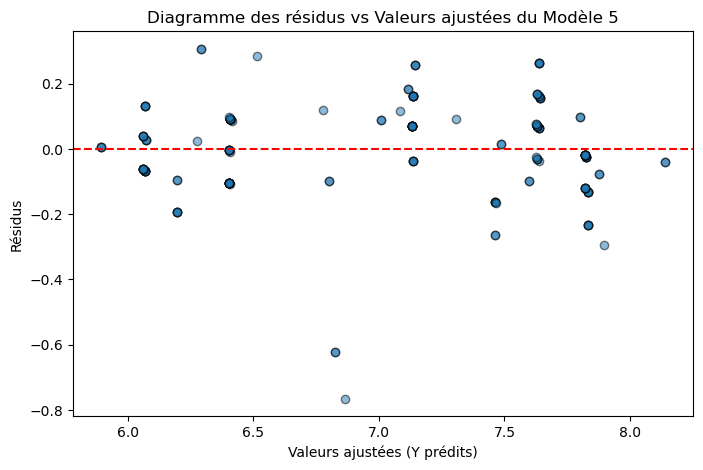

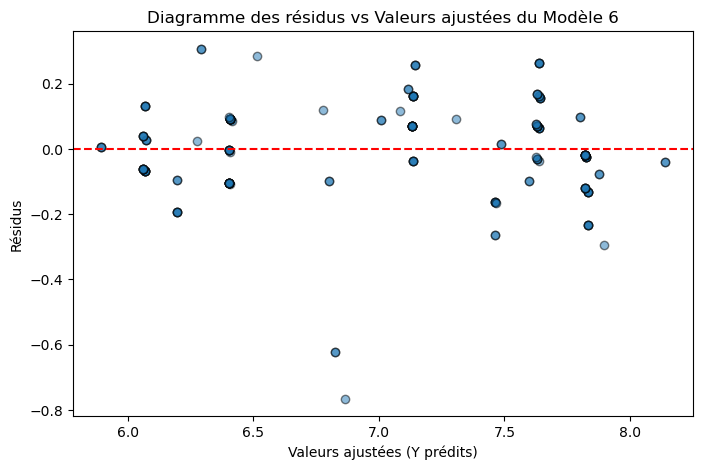

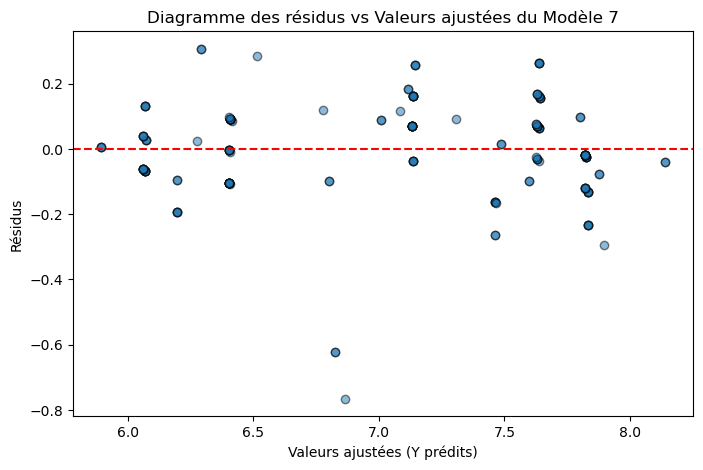

In [19]:
# üîπ Affichage du diagramme des r√©sidus vs valeurs ajust√©es
for i in range(len(liste_model)):
    plt.figure(figsize=(8, 5))
    plt.scatter(liste_model[i].fittedvalues, model_resid[i], alpha=0.5, edgecolors='black')
    plt.axhline(y=0, color='red', linestyle='dashed')  # Ligne horizontale √† z√©ro

    plt.xlabel("Valeurs ajust√©es (Y pr√©dits)")
    plt.ylabel("R√©sidus")
    plt.title(f"Diagramme des r√©sidus vs Valeurs ajust√©es du Mod√®le {i+1}")
    plt.show()

On s'aper√ßoit que notre h√©t√©rosc√©dasticit√© est toujours pr√©sente malgr√© les nombreux essais de changement du mod√®le.  
**On ne valide donc pas l'hypoth√®se de l'h√©t√©rosc√©dasticit√© du mod√®le.**

#### 6) Normalit√© des r√©sidus 

On affiche l'histogramme et le QQPlotdes r√©sidus, et on r√©alise les tests de Shapiro-Wilk et Jarque-Bera afin de tester la normalit√© des r√©sidus.

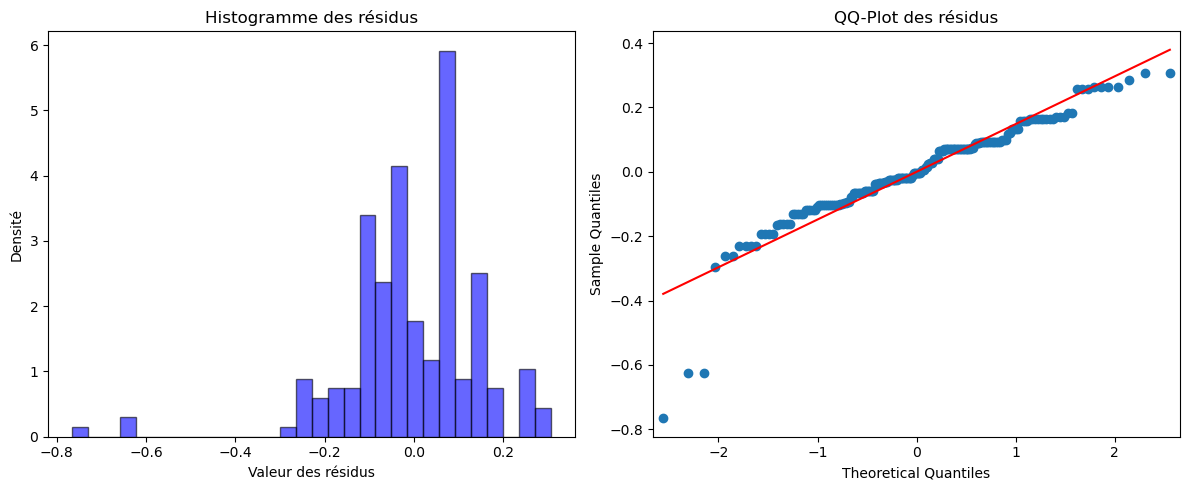

In [20]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(residuals, bins=30, density=True, alpha=0.6, color='b', edgecolor='black')
plt.title("Histogramme des r√©sidus")
plt.xlabel("Valeur des r√©sidus")
plt.ylabel("Densit√©")

# QQ-Plot
plt.subplot(1, 2, 2)
sm.qqplot(residuals, line='s', ax=plt.gca())
plt.title("QQ-Plot des r√©sidus")

plt.tight_layout()
plt.show()

In [21]:
#   Test de Shapiro-Wilk
shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk Test : Statistique = {shapiro_test.statistic:.4f}, p-value = {shapiro_test.pvalue:.4f}")

#   Test de Jarque-Bera
jarque_bera_test = jarque_bera(residuals)
print(f"Jarque-Bera Test : Statistique = {jarque_bera_test.statistic:.4f}, p-value = {jarque_bera_test.pvalue:.4f}")

# ‚úÖ Interpr√©tation
alpha = 0.05  # Seuil de signification
if shapiro_test.pvalue > alpha and jarque_bera_test.pvalue > alpha:
    print("‚úÖ Les r√©sidus suivent une distribution normale (on ne rejette pas H0).")
else:
    print("‚ùå Les r√©sidus ne suivent PAS une distribution normale (on rejette H0).")

Shapiro-Wilk Test : Statistique = 0.9095, p-value = 0.0000
Jarque-Bera Test : Statistique = 282.1347, p-value = 0.0000
‚ùå Les r√©sidus ne suivent PAS une distribution normale (on rejette H0).


On a essay√© de r√©aliser un bootstrap pour nous occuper de la distribution non-normale de nos r√©sidus, mais nous n'avons pas r√©ussi √† produire un r√©sultat probant.

#### 7) Calcul AIC / BIC

On calcule les crit√®res AIC et BIC de notre mod√®le.

In [22]:
n = X.shape[0]  # Nombre d'observations

# Ajout de la colonne de 1 pour l'intercept (Œ≤0)
X_b = np.c_[np.ones(n), X]

# Calcul de theta avec la formule des MCO
theta1 = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(Y)

n, p = X.shape  # Nombre d'observations et de variables explicatives

# Ajout de la constante (colonne de 1)
X_b = np.c_[np.ones(n), X]

# Pr√©dictions
Y_pred = X_b.dot(theta1)

# Erreurs r√©siduelles
residuals = Y - Y_pred

# SSE (Somme des carr√©s des erreurs)
SSE = np.sum(residuals ** 2)

# Calcul des crit√®res
AIC = n * np.log(SSE / n) + 2 * (p + 1)
BIC = n * np.log(SSE / n) + (p + 1) * np.log(n)

print("Crit√®re AIC :", AIC)
print("Crit√®re AIC :", BIC)

Crit√®re AIC : 2239.947971246693
Crit√®re AIC : 2269.12369438223


#### Tableau r√©capitulatif des √©tapes r√©alis√©es :

In [26]:
# D√©finition des donn√©es sous forme de dictionnaire
data = {
    "Hypoth√®se": [
        "Lin√©arit√©",
        "Significativit√© des coefficients",
        "Moyenne des r√©sidus nulle",
        "Non-corr√©lation des r√©sidus",
        "Homosc√©dasticit√©",
        "Normalit√© des r√©sidus"
    ],
    "Validation graphique": [
        "Scatterplot des r√©sidus : On semble valider l'hypoth√®se.",
        "-",
        "Histogramme des r√©sidus : On semble valider l'hypoth√®se.",
        "-",
        "Diagramme des r√©sidus et valeurs ajust√©es : On semble valider visuellement l'absence d'h√©t√©rosc√©dasticit√© (pas de c√¥ne).",
        "Histogramme et QQ-plot des r√©sidus : On ne valide pas l'hypoth√®se (probl√®mes √† gauche de l'histogramme et du QQplot)."
    ],
    "Validation avec Test": [
        f"Test de Ramsey RESET (p-value > 0.05) : {round(reset_test.pvalue, 3)}. On rejette l'hypoth√®se",
        f"Test de Fisher (p-value < 0.05): {round(p_value_F1, 3)}. Le mod√®le est statistiquement significatif.",
        f"Test de Student (p-value > 0.05): {p_value:.3f}. On valide l'hypoth√®se.",
        "-",
        f"Test de Breusch-Pagan (p-value > 0.05) : {bp_pvalue:.3f}. Test de White (p-value > 0.05): {white_pvalue:.3f}. On rejette l'hypoth√®se pour les deux tests.",
        f"Test de Shapiro-Wilk (p-value > 0.05) : {shapiro_test.pvalue:.3f}. Test de Jarque-Bera (p-value > 0.05) : {jarque_bera_test.pvalue:.3f}. On rejette l'hypoth√®se pour les deux tests."
    ],
    "Validation de l'hypoth√®se": [
        "Hypoth√®se non valid√©e",
        "Hypoth√®se valid√©e",
        "Hypoth√®se valid√©e",
        "Non trait√©, absence de temporalit√©",
        "Hypoth√®se non valid√©e",
        "Hypoth√®se non valid√©e"
    ]
}

# Cr√©ation du DataFrame
df = pd.DataFrame(data)
pd.set_option('display.max_colwidth', None)  # Ajuste la largeur des colonnes
pd.set_option('display.expand_frame_repr', True)  # Emp√™che le retour √† la ligne
pd.set_option('display.colheader_justify', 'left')  # Justifie le texte √† gauche
# Affichage du tableau
display(df)


Hypoth√®se                          \
0                         Lin√©arit√©   
1  Significativit√© des coefficients   
2         Moyenne des r√©sidus nulle   
3       Non-corr√©lation des r√©sidus   
4                  Homosc√©dasticit√©   
5             Normalit√© des r√©sidus   

  Validation graphique                                                                                                       \
0                                                                  Scatterplot des r√©sidus : On semble valider l'hypoth√®se.   
1                                                                                                                         -   
2                                                                  Histogramme des r√©sidus : On semble valider l'hypoth√®se.   
3                                                                                                                         -   
4  Diagramme des r√©sidus et valeurs ajust√©es : On semble valider visuellement l'absence d'h√©t√©rosc√©dasticit√© (pas de c√¥ne).   
5     Histogramme et QQ-plot des r√©sidus : On ne valide pas l'hypoth√®se (probl√®mes √† gauche de l'histogramme et du QQplot).   

  Validation avec Test                                                                                                                       \
0                                                                     Test de Ramsey RESET (p-value > 0.05) : 0.004. On rejette l'hypoth√®se   
1                                                         Test de Fisher (p-value < 0.05): 0.0. Le mod√®le est statistiquement significatif.   
2                                                                           Test de Student (p-value > 0.05): 1.000. On valide l'hypoth√®se.   
3                                                                                                                                         -   
4        Test de Breusch-Pagan (p-value > 0.05) : 0.002. Test de White (p-value > 0.05): 0.000. On rejette l'hypoth√®se pour les deux tests.   
5  Test de Shapiro-Wilk (p-value > 0.05) : 0.000. Test de Jarque-Bera (p-value > 0.05) : 0.000. On rejette l'hypoth√®se pour les deux tests.   

  Validation de l'hypoth√®se            
0               Hypoth√®se non valid√©e  
1                   Hypoth√®se valid√©e  
2                   Hypoth√®se valid√©e  
3  Non trait√©, absence de temporalit√©  
4               Hypoth√®se non valid√©e  
5               Hypoth√®se non valid√©e

In [24]:
tableau_recap = {"R¬≤":[f"{R2_1:.4f}"], "R2 ajust√©":[f"{R2_aj1:.4f}"], "AIC":[f"{AIC:.0f}"], "BIC":[f"{BIC:.0f}"]}
tableau = pd.DataFrame(tableau_recap)
display(tableau)

R¬≤      R2 ajust√© AIC   BIC  
0  0.9456  0.9438    2240  2269